In [1]:
from math import sin, cos, acos, radians
import collections
from sklearn.model_selection import train_test_split
#ランダムフォレスト
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import train_test_split, GridSearchCV
import math
from sklearn.cluster import KMeans
from IPython.display import Image
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import osmnx as ox
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
ox.config(use_cache=True, log_console=True)
ox.__version__

'0.9'

In [2]:
kokkaku = pd.read_csv('kokkaku_1000_hist.csv')

In [3]:
kokkaku.head()

,Unnamed: 0,Unnamed: 0.1,avg_neighbor_degree_avg,avg_weighted_neighbor_degree_avg,betweenness_centrality_avg,building_area,building_proportion,center,circuity_avg,clean_intersection_count,...,252,264,276,288,300,312,324,336,348,hist-std
0,0,0,2.055556,0.015626,0.124506,2.297682e+06,0.238112,[262656753],1.083378,9.0,...,0.050000,0.075000,0.025000,0.050000,0.025000,0.050000,0.000000,0.000000,0.025000,0.257660
1,1,0,3.180556,0.004945,0.166667,7.430192e+05,0.100828,[292656272],1.020684,5.0,...,0.000000,0.000000,0.041667,0.000000,0.083333,0.125000,0.000000,0.000000,0.000000,0.310018
2,2,0,1.921053,0.007978,0.152735,1.059110e+04,0.001767,[428020552],1.051872,12.0,...,0.000000,0.030303,0.060606,0.030303,0.030303,0.000000,0.000000,0.030303,0.030303,0.323250
3,3,0,2.981481,0.003186,0.198413,1.664818e+05,0.033225,[1256517413],1.046372,3.0,...,0.062500,0.000000,0.000000,0.125000,0.000000,0.000000,0.125000,0.000000,0.000000,0.304366
4,4,0,2.301587,0.012286,0.125815,1.700403e+06,0.131744,[463247944],1.093659,6.0,...,0.057143,0.000000,0.057143,0.000000,0.000000,0.057143,0.028571,0.114286,0.028571,0.245180


In [4]:
kokkaku = kokkaku.iloc[:,2:]

In [5]:
kokkaku_kai = kokkaku[[ 'clean_intersection_count',
       'street_length_avg', 
       'streets_per_node_avg', 'hist-std']]

In [7]:
#特徴量の正規化（min-maxを利用）
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
kokkaku_norm = mms.fit_transform(kokkaku_kai)

In [8]:
kokkaku_norm

array([[0.03524229, 0.13941638, 0.69749071, 0.1809944 ],
       [0.01762115, 0.26975358, 0.44052045, 0.32375916],
       [0.04845815, 0.15120152, 0.65691645, 0.3598386 ],
       ...,
       [0.01321586, 0.25650087, 0.44052045, 0.35703699],
       [0.10572687, 0.12966916, 0.50683535, 0.07481602],
       [0.0969163 , 0.13212909, 0.74179592, 0.07857151]])

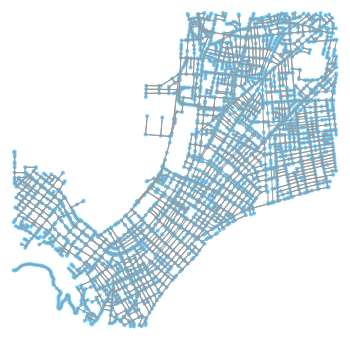

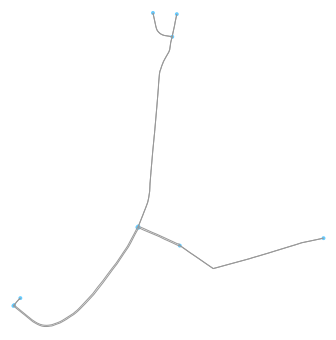

In [20]:
stations = pd.read_csv('station_latlon.csv')
for i in range(0, 1):
    station = [stations.iloc[i,5], stations.iloc[i,6]]
    G = ox.graph_from_point(station, distance=2000, network_type='drive', simplify=False)
    fig, ax = ox.plot_graph(ox.project_graph(G))
    hwy_types = ['motorway','trunk','trunk_link', 'motorway_link']
    gdf = ox.graph_to_gdfs(G, nodes=False)
    gdf
    mask = ~gdf['highway'].map(lambda x: isinstance(x, str) and x in hwy_types)
    edges = zip(gdf[mask]['u'], gdf[mask]['v'], gdf[mask]['key'])
    G.remove_edges_from(edges)
    G = ox.remove_isolated_nodes(G)
    G = ox.simplify_graph(G)
    fig, ax = ox.plot_graph(ox.project_graph(G))

In [25]:
gdf = ox.graph_to_gdfs(G,nodes=False)

In [26]:
gdf

,bridge,geometry,highway,key,lanes,length,maxspeed,name,oneway,osmid,ref,u,v,width
0,NaN,"LINESTRING (140.7281309 41.7726333, 140.727996...",trunk,0,2,11.702,40,NaN,True,152679615,278,2509425191,262647402,NaN
1,NaN,"LINESTRING (140.7281309 41.7726333, 140.728045...",trunk,0,"[2, 1]",1726.275,40,"[海峡通, 国道279号]",True,"[285738584, 696617817, 289418815]",279,2509425191,4139896403,NaN
2,yes,"LINESTRING (140.7493318 41.77176, 140.7492138 ...",trunk,0,4,1479.327,"[50, 40]",国道278号,False,"[289046000, 152679614, 24341260, 289045998]",278,5535566398,1654777378,NaN
3,NaN,"LINESTRING (140.713821 41.7657124, 140.7139022...",trunk,0,2,10.453,40,国道279号,False,24258961,279,4139896403,292281669,NaN
4,yes,"LINESTRING (140.7319264 41.7894578, 140.731761...",trunk,0,4,338.619,NaN,"[国道227号, 万代跨線橋]",False,"[104531876, 66959414, 66959415]",227;228,262656607,262656666,19.5
5,NaN,"LINESTRING (140.7319264 41.7894578, 140.731972...",trunk,0,4,225.594,NaN,国道5号,False,243553763,5,262656607,262659311,NaN
6,NaN,"LINESTRING (140.7319264 41.7894578, 140.731843...",trunk,0,4,1902.237,NaN,国道5号,False,243553763,5,262656607,262656753,NaN
7,yes,"LINESTRING (140.7297035 41.7915516, 140.729862...",trunk,0,4,338.619,NaN,"[国道227号, 万代跨線橋]",False,"[104531876, 66959414, 66959415]",227;228,262656666,262656607,19.5
8,NaN,"LINESTRING (140.7281007 41.772749, 140.7281309...",trunk,0,2,13.107,40,海峡通,True,289418815,279,262656753,2509425191,NaN
9,NaN,"LINESTRING (140.7281007 41.772749, 140.7283919...",trunk,0,2,443.290,40,国道278号,True,24259812,278,262656753,1654777378,NaN


In [8]:
#ノードとエッジの追加の仕方
G.add_node(33)
G.nodes[33]['x'] = 140.730703
G.nodes[33]['y'] = 41.791552
G.add_edge(33,262656666)

0

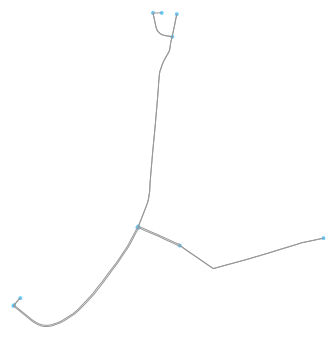

In [9]:
fig, ax = ox.plot_graph(ox.project_graph(G))

In [13]:
#edgeの情報
#{'osmid': 152679615,
#'oneway': True,
#'lanes': '2',
#'ref': '278',
#'highway': 'trunk',
#'maxspeed': '40',
#'length': 11.702}
#nodeの情報
#{'y': 41.7915516, 'x': 140.7297035, 'osmid': 262656666}

In [10]:
G.add_node(32)
G.nodes[32]['x'] = 140.720703
G.nodes[32]['y'] = 41.771552

G.add_node(31)
G.nodes[31]['x'] = 140.720703
G.nodes[31]['y'] = 41.781552

G.add_edge(33,31)
G.add_edge(31,32)

0

In [29]:
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj) #ノードの表

In [30]:
nodes_proj

(                    highway        lat         lon       osmid              x  \
 2509425191  traffic_signals  41.772633  140.728131  2509425191  477404.465203   
 5535566398         crossing  41.771760  140.749332  5535566398  479166.229275   
 4139896403  traffic_signals  41.765712  140.713821  4139896403  476212.585729   
 262656607   traffic_signals  41.789458  140.731926   262656607  477725.739507   
 262656666               NaN  41.791552  140.729703   262656666  477541.769215   
 262656753   traffic_signals  41.772749  140.728101   262656753  477401.995834   
 262659311               NaN  41.791450  140.732437   262659311  477768.878641   
 292281667   traffic_signals  41.766402  140.714616   292281667  476278.879137   
 292281669   traffic_signals  41.765784  140.713902   292281669  476219.361692   
 1654777378  traffic_signals  41.771065  140.732865  1654777378  477797.376238   
 262647402   traffic_signals  41.772665  140.727996   262647402  477393.289439   
 
              

In [12]:
earth_rad = 6378.137
def latlng_to_xyz(lat, lng):
    rlat, rlng = radians(lat), radians(lng)
    coslat = cos(rlat)
    return coslat*cos(rlng), coslat*sin(rlng), sin(rlat)

def dist_on_sphere(lat1,lon1,lat2,lon2, radius=earth_rad):
    xyz0, xyz1 = latlng_to_xyz(lat1, lon1), latlng_to_xyz(lat2,lon2)
    return acos(sum(x * y for x, y in zip(xyz0, xyz1)))*radius*1000
nodelength = dist_on_sphere(nodes_proj.iloc[-3,1],nodes_proj.iloc[-3,2],nodes_proj.iloc[-1,1],nodes_proj.iloc[-1,2], radius=earth_rad)
nodelength2 = dist_on_sphere(nodes_proj.iloc[-2,1],nodes_proj.iloc[-2,2],nodes_proj.iloc[-1,1],nodes_proj.iloc[-1,2], radius=earth_rad)
print(nodelength)
print(nodelength2)

1388.581898692233
1113.1949060017068


In [13]:
G.edges[33,31,0]['length'] = nodelength
G.edges[31,32,0]['length'] = nodelength2

In [15]:
G = ox.simplify_graph(G)

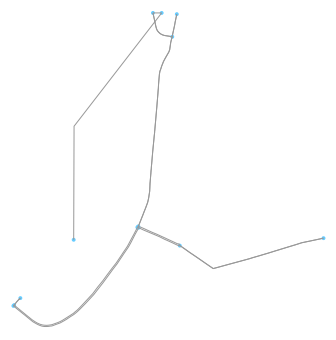

In [16]:
fig, ax = ox.plot_graph(ox.project_graph(G))

In [17]:
G.add_node(38)
G.nodes[38]['x'] = 140.725703
G.nodes[38]['y'] = 41.774352

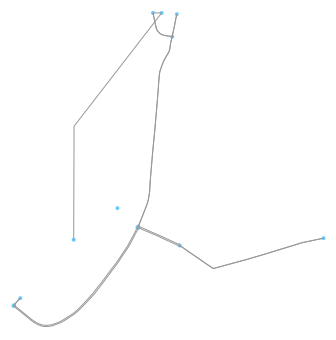

In [18]:
fig, ax = ox.plot_graph(ox.project_graph(G))

In [32]:
G.add_edge(34,35)
G.add_edge(35,36)
G.add_edge(36,37)
G.add_edge(37,38)

0

In [ ]:
#道路の特徴の学習をどうするか？
#道路生成の方法について？
#

In [19]:
#既存の道路に対して、ある条件を満たす場合に道路を追加する

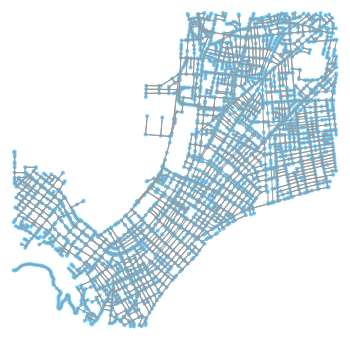

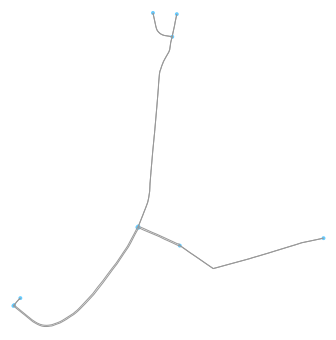

In [31]:
stations = pd.read_csv('station_latlon.csv')
for i in range(0, 1):
    station = [stations.iloc[i,5], stations.iloc[i,6]]
    G = ox.graph_from_point(station, distance=2000, network_type='drive', simplify=False)
    fig, ax = ox.plot_graph(ox.project_graph(G))
    hwy_types = ['motorway','trunk','trunk_link', 'motorway_link']
    gdf = ox.graph_to_gdfs(G, nodes=False)
    gdf
    mask = ~gdf['highway'].map(lambda x: isinstance(x, str) and x in hwy_types)
    edges = zip(gdf[mask]['u'], gdf[mask]['v'], gdf[mask]['key'])
    G.remove_edges_from(edges)
    G = ox.remove_isolated_nodes(G)
    G = ox.simplify_graph(G)
    fig, ax = ox.plot_graph(ox.project_graph(G))

In [34]:
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj,edges=False) #ノードの表

In [35]:
#ノードの番号を得る
nodes_proj

,highway,lat,lon,osmid,x,y,geometry
2509425191,traffic_signals,41.772633,140.728131,2509425191,477404.465203,4.624568e+06,POINT (477404.4652031656 4624568.1747216)
5535566398,crossing,41.771760,140.749332,5535566398,479166.229275,4.624466e+06,POINT (479166.2292749028 4624465.864259386)
4139896403,traffic_signals,41.765712,140.713821,4139896403,476212.585729,4.623804e+06,POINT (476212.5857293808 4623803.643456749)
262656607,traffic_signals,41.789458,140.731926,262656607,477725.739507,4.626435e+06,POINT (477725.7395072667 4626435.120350852)
262656666,NaN,41.791552,140.729703,262656666,477541.769215,4.626668e+06,POINT (477541.7692149241 4626668.162623031)
262656753,traffic_signals,41.772749,140.728101,262656753,477401.995834,4.624581e+06,POINT (477401.9958339554 4624581.028200931)
262659311,NaN,41.791450,140.732437,262659311,477768.878641,4.626656e+06,POINT (477768.8786408749 4626656.18307949)
292281667,traffic_signals,41.766402,140.714616,292281667,476278.879137,4.623880e+06,POINT (476278.8791365065 4623879.953219729)
292281669,traffic_signals,41.765784,140.713902,292281669,476219.361692,4.623812e+06,POINT (476219.3616916185 4623811.603664101)
1654777378,traffic_signals,41.771065,140.732865,1654777378,477797.376238,4.624393e+06,POINT (477797.3762380619 4624392.877519787)


In [36]:
nodes_index = list(nodes_proj.index)

In [37]:
nodes_index

[2509425191,
 5535566398,
 4139896403,
 262656607,
 262656666,
 262656753,
 262659311,
 292281667,
 292281669,
 1654777378,
 262647402]

In [38]:
for i in range(len(nodes_index)):
    print(G.degree[nodes_index[i]])

4
2
3
6
2
5
2
2
5
4
3


In [39]:
nx.number_of_nodes(G)
nx.number_of_edges(G)

19